In [1]:
# Read elevation raster
# ----------------------------
from pysheds.grid import Grid
import numpy as np

grid = Grid.from_raster("./dem/贵阳/贵阳.tif")
dem = grid.read_raster("./dem/贵阳/贵阳.tif")

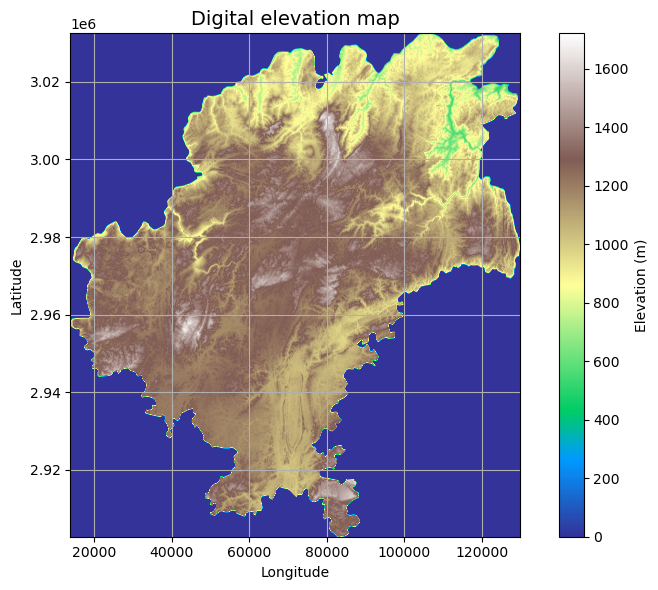

In [2]:
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns

fig, ax = plt.subplots(figsize=(8, 6))
fig.patch.set_alpha(0)

plt.imshow(dem, extent=grid.extent, cmap="terrain", zorder=1)
plt.colorbar(label="Elevation (m)")
plt.grid(zorder=0)
plt.title("Digital elevation map", size=14)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.tight_layout()

In [3]:
# Condition DEM
# ----------------------
# Fill pits in DEM
pit_filled_dem = grid.fill_pits(dem)

# Fill depressions in DEM
# TODO: I don't know why the result is warning!
flooded_dem = grid.fill_depressions(pit_filled_dem)

# Resolve flats in DEM
# TODO: I don't know why the result is warning!
inflated_dem = grid.resolve_flats(flooded_dem)

In [8]:
grid.to_raster(
    pit_filled_dem,
    "./dem/贵阳/pit_filled_dem.tif",
    apply_output_mask=True,
    blockxsize=16,
    blockysize=16,
)
grid.to_raster(
    flooded_dem,
    "./dem/贵阳/flooded_dem.tif",
    apply_output_mask=True,
    blockxsize=16,
    blockysize=16,
)
grid.to_raster(
    inflated_dem,
    "./dem/贵阳/inflated_dem.tif",
    apply_output_mask=True,
    blockxsize=16,
    blockysize=16,
)

In [4]:
# Determine D8 flow directions from DEM
# ----------------------
# Specify directional mapping
dirmap = (64, 128, 1, 2, 4, 8, 16, 32)

# Compute flow directions
# -------------------------------------
fdir = grid.flowdir(inflated_dem, dirmap=dirmap)

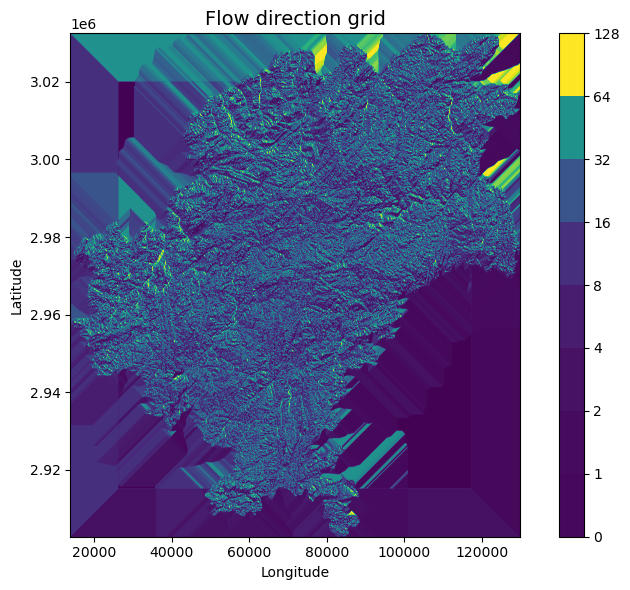

In [5]:
fig = plt.figure(figsize=(8, 6))
fig.patch.set_alpha(0)

plt.imshow(fdir, extent=grid.extent, cmap="viridis", zorder=2)
boundaries = [0] + sorted(list(dirmap))
plt.colorbar(boundaries=boundaries, values=sorted(dirmap))
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Flow direction grid", size=14)
plt.grid(zorder=-1)
plt.tight_layout()

In [6]:
# Calculate flow accumulation
# --------------------------
acc = grid.accumulation(fdir, dirmap=dirmap)


In [ ]:
grid.to_raster(
    acc,
    "./dem/贵阳/acc.tif",
    apply_output_mask=True,
    blockxsize=16,
    blockysize=16,
)

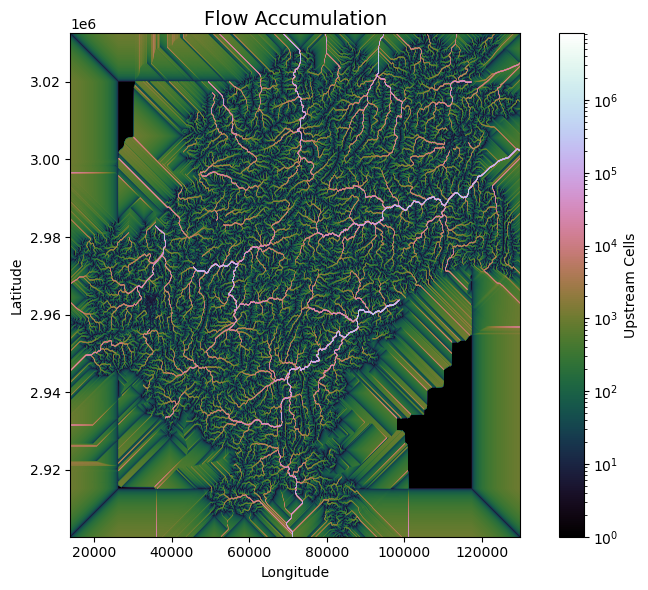

In [7]:
fig, ax = plt.subplots(figsize=(8, 6))
fig.patch.set_alpha(0)
plt.grid("on", zorder=0)
im = ax.imshow(
    acc,
    extent=grid.extent,
    zorder=2,
    cmap="cubehelix",
    norm=colors.LogNorm(1, acc.max()),
    interpolation="bilinear",
)
plt.colorbar(im, ax=ax, label="Upstream Cells")
plt.title("Flow Accumulation", size=14)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.tight_layout()

In [16]:
import fiona

# Delineate a catchment
x, y = 106.86622934, 27.21131557

# Snap pour point to high accumulation cell
x_snap, y_snap = grid.snap_to_mask(acc > 500, (x, y))

# Delineate the catchment
catch = grid.catchment(
    x=x_snap, y=y_snap, fdir=fdir, dirmap=dirmap, xytype="coordinate"
)

# Crop and plot the catchment
# ---------------------------
# Clip the bounding box to the catchment
grid.clip_to(catch)
clipped_catch = grid.view(catch)

clipped_catch_temp = grid.view(catch, dtype=np.uint8)

# Create a vector representation of the catchment mask
shapes = grid.polygonize(clipped_catch_temp)

# Specify schema
schema = {"geometry": "Polygon", "properties": {"LABEL": "float:16"}}

# Write shapefile
with fiona.open(
    "./dem/贵阳/集水区/经纬度测试集水区3.shp",
    "w",
    driver="ESRI Shapefile",
    crs=grid.crs.srs,
    schema=schema,
) as c:
    i = 0
    for shape, value in shapes:
        rec = {}
        rec["geometry"] = shape
        rec["properties"] = {"LABEL": str(value)}
        rec["id"] = str(i)
        c.write(rec)
        i += 1  

In [34]:
import rasterio


def get_row_col_from_lat_lon(lat, lon, raster_path):
    # 打开栅格文件
    with rasterio.open(raster_path) as src:
        # 获取变换矩阵
        transform = src.transform

        # 使用rasterio的index方法获取行列号
        row, col = src.index(lon, lat)

        return row, col


# Delineate a catchment
x, y = 106.86622934, 27.21131557
print(get_row_col_from_lat_lon(x, y, "./dem/贵阳/inflated_dem.tif"))

# temp_col, temp_row = grid.nearest_cell(x, y, fdir.affine, snap="corner")
# temp_col, temp_row = grid.nearest_cell(x, y, fdir.affine)
# temp_col, temp_row



(242749, -1113)


In [33]:
grid.index(x, y)

AttributeError: 'sGrid' object has no attribute 'index'

In [24]:
x, y

(106.86622934, 27.21131557)

In [10]:
import fiona

# Reset the view
grid.viewfinder = fdir.viewfinder

# Find the row and column index corresponding to the pour point
col, row = 6124, 1271

# Delineate the catchment
catch = grid.catchment(x=col, y=row, fdir=fdir, xytype="index")

# Plot the result
grid.clip_to(catch)
clipped_catch = grid.view(catch)

clipped_catch_temp = grid.view(catch, dtype=np.uint8)

# Create a vector representation of the catchment mask
shapes = grid.polygonize(clipped_catch_temp)

# Specify schema
schema = {"geometry": "Polygon", "properties": {"LABEL": "float:16"}}

# Write shapefile
with fiona.open(
    "./dem/贵阳/集水区/行列测试集水区4.shp",
    "w",
    driver="ESRI Shapefile",
    crs=grid.crs.srs,
    schema=schema,
) as c:
    i = 0
    for shape, value in shapes:
        rec = {}
        rec["geometry"] = shape
        rec["properties"] = {"LABEL": str(value)}
        rec["id"] = str(i)
        c.write(rec)
        i += 1

Text(0.5, 1.0, 'Delineated Catchment')

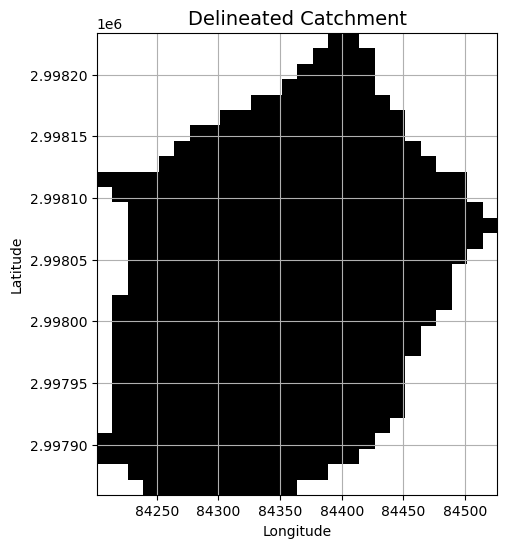

In [15]:
# Plot the catchment
fig, ax = plt.subplots(figsize=(8, 6))
fig.patch.set_alpha(0)

plt.grid("on", zorder=0)
im = ax.imshow(
    np.where(clipped_catch, clipped_catch, np.nan),
    extent=grid.extent,
    zorder=1,
    cmap="Greys_r",
)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Delineated Catchment", size=14)

In [12]:
# Extract river network
# ---------------------
branches = grid.extract_river_network(fdir, acc > 500, dirmap=dirmap)

# 定义 schema
schema = {
    "geometry": "LineString",  # 根据你的特征集合中的几何类型来定义
}

# 写入 Shapefile
with fiona.open(
    "./dem/贵阳/集水区/行列测试集水区河网4_500.shp",
    "w",
    driver="ESRI Shapefile",
    crs=grid.crs.srs,
    schema=schema,
) as output:
    # 写入特征集合中的每个特征
    for feature in branches["features"]:
        output.write(
            feature
        )

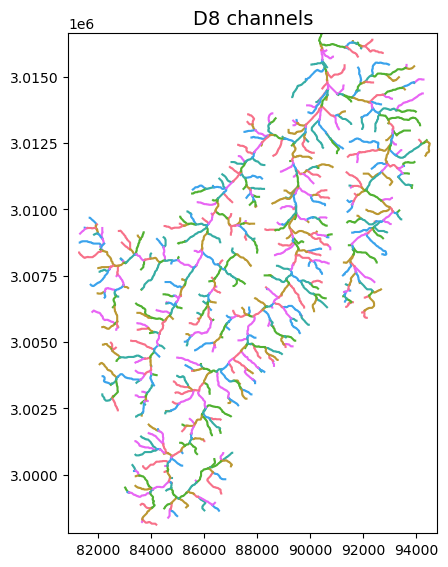

In [13]:
sns.set_palette("husl")
fig, ax = plt.subplots(figsize=(8.5, 6.5))

plt.xlim(grid.bbox[0], grid.bbox[2])
plt.ylim(grid.bbox[1], grid.bbox[3])
ax.set_aspect("equal")

for branch in branches["features"]:
    line = np.asarray(branch["geometry"]["coordinates"])
    plt.plot(line[:, 0], line[:, 1])

_ = plt.title("D8 channels", size=14)

In [15]:
# Convert catchment raster to vector
# Read soils shapefile
import pandas as pd
import geopandas as gpd
from shapely import geometry, ops

# Convert catchment raster to vector geometry and find intersection
shapes = grid.polygonize()
catchment_polygon = ops.unary_union([geometry.shape(shape) for shape, value in shapes])
gdf = gpd.GeoDataFrame(geometry=[catchment_polygon])
gdf.to_file('./dem/测试数据对比/pysheds数据/集水区/集水区.shp')



In [39]:
# Convert catchment raster to vector
# Read soils shapefile
import pandas as pd
import geopandas as gpd
from shapely import geometry, ops

# Convert catchment raster to vector geometry and find intersection
shapes = branches.polygonize()
catchment_polygon = ops.unary_union([geometry.shape(shape) for shape, value in shapes])
gdf = gpd.GeoDataFrame(geometry=[catchment_polygon])
gdf.to_file("./dem/测试数据对比/pysheds数据/集水区/集水区.shp")

AttributeError: polygonize